In [25]:
import numpy as np
import matplotlib.pyplot as plt
'''
Zeroth Order Regularized Optimization (ZORO)
with Block/Circulant Sensing Matrix, and Block Coordinate Descent
by Yuchen Lou 2020.7
'''

'\nZeroth Order Regularized Optimization (ZORO)\nwith Block/Circulant Sensing Matrix, and Block Coordinate Descent\nby Yuchen Lou 2020.7\n'

In [26]:
def SparseQuadratic(x_in,function_params):
    '''
    Function that calculates the noisy quadratic evaluation
    val = x^TQx, Q is diagonal with sparse value 1 entries
    '''
    sigma = function_params.sigma
    S = function_params.S
    D = function_params.D
    
    noise  = sigma*np.random.randn()/np.sqrt(D)
    val = np.dot(x_in[S],x_in[S])+noise
    grad = np.zeros(D)
    grad[S] = 2*x_in[S]
    return val,grad

In [27]:
def SparseP4(x_in,function_params):
    sigma = function_params.sigma
    S = function_params.S
    D = function_params.D

    noise = sigma*np.random.randn()/np.sqrt(D)
    val = np.sum(np.power(x_in[S],4)) + noise
    grad = np.zeros(D)
    grad[S] = 4*np.power(x_in[S],3)
    return val,grad

In [28]:
def cosamp(Phi, u, s, tol, max_iter):
    #CoSaMP by rfmiotto from GitHub
    #Copyright (c) 2019 rfmiotto
    max_iter -= 1 # Correct the while loop
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter = 0
    halt = False
    while not halt:
        iter += 1
        #print("Iteration {}\r".format(iter))
        
        y = abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2*s] and val > num_precision] # quivalent to below
        #Omega = np.argwhere(y >= np.sort(y)[::-1][2*s] and y > num_precision)
        T = np.union1d(Omega, a.nonzero()[0])
        #T = np.union1d(Omega, T)
        b = np.dot( np.linalg.pinv(Phi[:,T]), u )
        igood = (abs(b) > np.sort(abs(b))[::-1][s]) & (abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:,T], b[igood])
        
        halt = np.linalg.norm(v)/np.linalg.norm(u) < tol or \
               iter > max_iter
        
    return a

In [29]:
def BlockCosampGradEstimate(function_handle,x,cosamp_params,function_params):
    #Gradient estimation in ZORO, based on CoSaMP with Randemancher matrix
    maxiterations = cosamp_params.maxiterations
    Z = cosamp_params.Z
    delta = cosamp_params.delta
    sparsity = cosamp_params.sparsity
    tol = cosamp_params.tol
    block = cosamp_params.block
    num_samples = np.size(Z,0);
    dim = len(x)
    
    Z_padded = np.zeros((num_samples,dim))
    Z_padded[:,block] = Z;
    
    y = np.zeros(num_samples)
    function_estimate = 0
    
    for i in range(num_samples):
        y_temp, _ = eval('SparseQuadratic')(x + delta*np.transpose(Z_padded[i,:]),function_params)
        y_temp2, _ = eval('SparseQuadratic')(x,function_params)
        function_estimate = function_estimate + y_temp2
        y[i] = (y_temp-y_temp2) / (np.sqrt(num_samples)*delta)
    
    Z = Z/np.sqrt(num_samples)
    block_grad_estimate = cosamp(Z,y,sparsity,tol,maxiterations)
    grad_estimate = np.zeros(dim)
    grad_estimate[block] = block_grad_estimate
    function_estimate = function_estimate/num_samples # averaging the noise
    
    return function_estimate,grad_estimate

In [30]:
def CosampGradEstimate(function_handle,x,cosamp_params,function_params):
    #Gradient estimation in ZORO, based on CoSaMP with Randemancher matrix
    #Gradient estimation in ZORO, based on CoSaMP with Randemancher matrix
    maxiterations = cosamp_params.maxiterations
    Z = cosamp_params.Z
    delta = cosamp_params.delta
    sparsity = cosamp_params.sparsity
    tol = cosamp_params.tol
    num_samples = np.size(Z,0);
    
    
    y = np.zeros(num_samples)
    function_estimate = 0
    
    for i in range(num_samples):
        y_temp, _ = eval('SparseQuadratic')(x + delta*np.transpose(Z[i,:]),function_params)
        y_temp2, _ = eval('SparseQuadratic')(x,function_params)
        function_estimate = function_estimate + y_temp2
        y[i] = (y_temp-y_temp2) / (np.sqrt(num_samples)*delta)
    
    Z = Z/np.sqrt(num_samples)
    grad_estimate = cosamp(Z,y,sparsity,tol,maxiterations)
    function_estimate = function_estimate/num_samples # averaging the noise
    
    return function_estimate,grad_estimate

In [35]:
from scipy.linalg import circulant
def Block_ZORO(function_handle, function_params, ZORO_params):
    #
    x = ZORO_params.x0
    Type = ZORO_params.Type
    sparsity = ZORO_params.sparsity
    delta1 = ZORO_params.delta1
    grad_estimate = ZORO_params.init_grad_estimate
    num_iterations = ZORO_params.num_iterations
    step_size = ZORO_params.step_size
    
    D = function_params.D
    
    f_vals = np.zeros(num_iterations)
    # time_vec = np.zeros(num_iterations)
    
    class cosamp_params:
        pass
    num_samples = 4*sparsity
    cosamp_params.maxiterations = ZORO_params.cosamp_max_iter
    cosamp_params.tol = 0.5
    cosamp_params.sparsity = sparsity
    oversampling_param = 1.5
    
    if (Type == 'Full'):
        Z = 2*(np.random.rand(num_samples,D) > 0.5) - 1
    elif (Type == 'FullCirculant'):
        z1 = 2*(np.random.rand(1,D) > 0.5) - 1
        Z1 = circulant(z1)
        SSet = np.random.choice(D, num_samples, replace=False)
        Z = Z1[SSet,:]
    else:
        J = ZORO_params.num_blocks
        samples_per_block = np.ceil(oversampling_param*num_samples/J)
        samples_per_block = int(samples_per_block)
        block_size = int(D/J)
        if (Type == 'FullBD'):
            Z = np.zeros((num_samples,D))
            Z1 = 2*(np.random.rand(samples_per_block,block_size) > 0.5) - 1
            for i in range(J):
                Z[(samples_per_block*i+1):(samples_per_block*i+samples_per_block),(block_size*i+1):(block_size*i+block_size)] = Z1
        elif (Type == 'FullBC'):
            z1 = 2*(np.random.rand(1,block_size) > 0.5) - 1
            Z1 = circulant(z1)
            SSet = np.random.choice(block_size,samples_per_block, replace=False)
            Z2 = Z1[SSet,:]
            Z = np.zeros((num_samples, D))
            for i in range(J):
                Z[(samples_per_block*i+1):(samples_per_block*i+samples_per_block),(block_size*i+1):(block_size*i+block_size)] = Z2
        else:
            sparsity = np.ceil(oversampling_param*sparsity/J)
            sparsity = int(sparsity)
            cosamp_params.sparsity = sparsity
            if (Type == 'BCD'):
                Z = 2*(np.random.rand(samples_per_block,block_size) > 0.5) - 1
            elif (Type == 'BCCD'):
                z1 = 2*(np.random.rand(1,block_size) > 0.5) - 1
                Z1 = circulant(z1)
                SSet = np.random.choice(block_size,samples_per_block, replace=False)
                Z = Z1[SSet,:]
    
    cosamp_params.Z = Z
    # Now do ZORO
    if (Type == 'BCD') or (Type == 'BCCD'):
        for i in range(num_iterations):
            cosamp_params.delta = delta1*np.linalg.norm(grad_estimate)
            coord_index = np.random.randint(J) + 1
            block = np.arange((coord_index-1)*block_size, coord_index*block_size)
            cosamp_params.block = block
            f_est,grad_estimate = BlockCosampGradEstimate(function_handle,x,cosamp_params,function_params)
            x = x - step_size*grad_estimate
            f_vals[i] = f_est
            # Time function to be added
            if (sparsity == 0):
                break
    else:
        for i in range(num_iterations):
            cosamp_params.delta = delta1*np.linalg.norm(grad_estimate)
            f_est,grad_estimate = CosampGradEstimate(function_handle,x,cosamp_params,function_params)
            x = x - step_size*grad_estimate
            f_vals[i] = f_est
            # Time function to be added
            if (sparsity == 0):
                break
    x_hat = x
    
    return x_hat, f_vals
            

In [48]:
'''Test on Block-ZORO'''
class function_params:
    pass
class ZORO_params:
    pass

# Function parameters
function_params.D = 3000
s = 300
function_params.S = np.random.choice(function_params.D, s, replace=False)
function_params.sigma = 0.01

# ZORO parameters
ZORO_params.num_iterations = 30
ZORO_params.delta1 = 0.0005
ZORO_params.sparsity = s
ZORO_params.step_size = 0.5
ZORO_params.x0 = 10*np.random.randn(function_params.D)
ZORO_params.init_grad_estimate = 2*np.linalg.norm(ZORO_params.x0[function_params.S])
ZORO_params.num_blocks = 5
function_handle = "SparseQuadratic"

# Run Full ZORO
ZORO_params.Type = "Full"
ZORO_params.cosamp_max_iter = np.ceil(4*np.log(function_params.D))
x_hat,f_vals = Block_ZORO(function_handle,function_params,ZORO_params)


# Run Block ZORO
ZORO_params.Type = "BCD"
ZORO_params.cosamp_max_iter = np.ceil(4*np.log(function_params.D/ZORO_params.num_blocks))
ZORO_params.num_iterations = ZORO_params.num_blocks*ZORO_params.num_iterations
x_hat_b,f_vals_b = Block_ZORO(function_handle,function_params,ZORO_params)


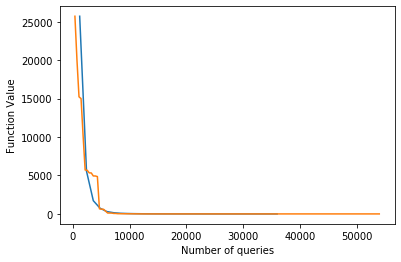

In [50]:
#Plot the results
num_queries = 4*s*np.arange(1,ZORO_params.num_iterations/ZORO_params.num_blocks + 1)
num_queries_b = 1.5*4*s/5*np.arange(1,ZORO_params.num_iterations + 1)
plt.plot(num_queries,f_vals)
plt.plot(num_queries_b,f_vals_b)
plt.xlabel('Number of queries')
plt.ylabel('Function Value')
plt.show()